<a href="https://colab.research.google.com/github/mlotfian/SDM-Analysis/blob/main/Thesis_SDM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Maryam Lotfian, *PhD student at Politecnico di Milano, and university of Appplied Sciences and Arts Western Switzerland (HEIG_VD)*

This notebook present the analysis of part of my PhD thesis which regards the generation of Species Distribution Models (SDM) for bird species. The idea of having this notebook is to promote open science and the reproducability of scientific analysis.

Our objective is to use SDM to validate location of observations in our biodiversity citizen science project called BioSenCS. In this project, we aim at combining machine learning techniques with citizen science to first validate biodiversity observations, and second give real-time feedback to the participants. This way, we are trying on the one hand to improve and speed up validation task, and on the other hand to provide an opportunity for volunteers to learn about biodiversity by them giving feedback reagrding their contributions, such as information regarding species habitat, breeding period, potential species to be observed based on volunteers' locations (user-centered feedback).  
In this notebook, we start first by giving a literature review on the various approaches used for SDM genertion and comparison of the models, then we present our data used to generate SDM, the methods used to produce pres-abs / pres-background datasets, the spatial k-fold cross validation, and finally once our dataset is ready we train four algorithms (naive Baysian, Random Forest, Balanced Random Forest, and ANN), and we compare the accuracy of these models, and decide which one to use for validating bird species in our citizen science biodiversity application. At the end, we discuss what is new in this approach compared to other citizen science biodiverstiy validation, and we also discuss the benefits, risks and challenges of using this approach for biodiversity validation. We will discuss at the end how this appraoch can be explanded for other organisms, and more importantly how it can be used for other citizen science projects besides biodiversity. 

*Note 1: before each cell of codes there is a text cell that explains the code and its purpose.*

*Note 2: Parts of this work has been presented in international conferences such as ICC 2019, ECSA 2020, CitSci helvetica 2021.* 

# Species Distribution Modeling:
Species Distribution Modeling (SDM) are numerical models that explains how the location of species observations is related to the environmental and landsacpe characteristics [[1]](https://www.mendeley.com/reference-manager/reader/d700fb14-8316-36b0-af98-a84547f10763/0134fa33-bb22-2faf-564f-04f83096ee65). They are used to gain ecological and evolutionary insights and to predict distributions across landscapes, sometimes requiring extrapolation in space and time. SDM is defined as a model which builds the connection between species distribution (occurance or abundance) with surface environmental characteristics (such as land cover, elevation, etc.). One can use SDM to both understand how the dstribution of species is correlated with it's location, and also to make predictions of species occurance locations where no data is available. "There are various other terms for SDM including bioclimatic models, ecological niche models, habitat models, resource selection functions, range maps, correlative models or spatial models." [[1]](https://www.mendeley.com/reference-manager/reader/d700fb14-8316-36b0-af98-a84547f10763/0134fa33-bb22-2faf-564f-04f83096ee65). Initial ecologists had access to a limitted geospatial data including latitude, longitude, or elevation, however, with advances in GIS and the availability of new tools and software such as easyily accessible satellite images, possibility to obtain 3D terrain model, etc. have made it easier to obtain a wider range of data to use for SDM. SDM is more challenging for organisms that move in space (mobile species) comapred to the onces which are sessile (fixed location). the reason is that for the sessile species the environemental characteristics is not changing and thus it is easier to model the distribution of such species. While for species that move from one area to another, it is a big chellenge to model the habitat of such species and to make predictions of their occurence.



In [ ]:
# install some packages

!pip install git+git://github.com/geopandas/geopandas.git
!pip install pyshp
!pip install pyreproj
!pip install spacv
!pip install sklearn
!pip install -U imbalanced-learn

In [ ]:
#import packages

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import fiona
import shapefile
import matplotlib.pyplot as plt

import rasterio
from rasterio.mask import mask
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
from pyreproj import Reprojector
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
#from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import spacv
from spacv.grid_builder import *
from spacv.utils import *
import unittest
from imblearn.ensemble import BalancedRandomForestClassifier
warnings.filterwarnings('ignore')


In [ ]:
# some functions we used during the rest of the script

# converting dataframe to geodataframe [replace geometry with the name of the column where the geometry is registered]
def convert_to_gdp(df):
    from shapely import wkt
    df = gpd.GeoDataFrame(df)

    df['geometry'] = df['geometry'].apply(wkt.loads)
    df = df.set_geometry('geometry')
    return df


# clip points inside polygons

def clip_points(targets,poly):
  test_target = targets.intersection(poly)
  test_target =pd.DataFrame(test_target)
  test_target = test_target.rename(columns={0: 'geometry'})
  to_remove_index =[]
  to_get_index =[]
  for index, row in test_target.iterrows():
    if row['geometry'].is_empty:
      to_remove_index.append(index)
  test_target = test_target.drop(to_remove_index)
  for index, row in test_target.iterrows():
    to_get_index.append(index)
  test_target = targets.loc[to_get_index, :]

  return test_target

In [ ]:
# read all species  scientific names
all_birds_pres = pd.read_csv('all_birds_pres.csv')
all_names = all_birds_pres.scientificname.unique()
print("There are {} species with at least 100 data points".format(len(all_names)))

```array(['Aythya fuligula', 'Turdus torquatus', 'Ptyonoprogne rupestris',
       'Fulica atra', 'Aquila chrysaetos', 'Prunella collaris',
       'Podiceps cristatus', 'Anas platyrhynchos', 'Regulus regulus',
       'Lophophanes cristatus', 'Emberiza citrinella',
       'Nucifraga caryocatactes', 'Picus viridis', 'Corvus corone',
       'Emberiza schoeniclus', 'Larus michahellis',
       'Luscinia megarhynchos', 'Mergus merganser', 'Gallinula chloropus',
       'Ficedula hypoleuca', 'Phylloscopus trochilus', 'Spatula clypeata',
       'Cygnus olor', 'Chroicocephalus ridibundus',
       'Acrocephalus scirpaceus', 'Anser anser', 'Phylloscopus bonelli',
       'Pica pica', 'Netta rufina', 'Oenanthe oenanthe',
       'Ciconia ciconia', 'Rallus aquaticus', 'Certhia familiaris',
       'Corvus frugilegus', 'Apus apus', 'Serinus serinus',
       'Turdus merula', 'Passer domesticus', 'Apus melba',
       'Anthus trivialis', 'Poecile montanus', 'Regulus ignicapilla',
       'Motacilla alba', 'Alcedo atthis', 'Phoenicurus phoenicurus',
       'Alauda arvensis', 'Sylvia borin', 'Columba oenas',
       'Lanius collurio', 'Falco tinnunculus', 'Milvus migrans',
       'Corvus monedula', 'Passer montanus', 'Tachybaptus ruficollis',
       'Ardea alba', 'Motacilla flava', 'Dryocopus martius',
       'Turdus viscivorus', 'Prunella modularis', 'Cuculus canorus',
       'Cyanistes caeruleus', 'Larus canus', 'Aythya ferina',
       'Mareca strepera', 'Ardea cinerea', 'Phylloscopus collybita',
       'Fringilla montifringilla', 'Chloris chloris',
       'Sylvia atricapilla', 'Phoenicurus ochruros', 'Muscicapa striata',
       'Cinclus cinclus', 'Linaria cannabina', 'Anas crecca',
       'Fringilla coelebs', 'Anthus spinoletta', 'Certhia brachydactyla',
       'Dendrocopos major', 'Parus major', 'Sturnus vulgaris',
       'Turdus pilaris', 'Aegithalos caudatus', 'Periparus ater',
       'Milvus milvus', 'Pyrrhula pyrrhula', 'Columba palumbus',
       'Coccothraustes coccothraustes', 'Buteo buteo',
       'Streptopelia decaocto', 'Spinus spinus', 'Erithacus rubecula',
       'Delichon urbicum', 'Carduelis carduelis', 'Poecile palustris',
       'Garrulus glandarius', 'Troglodytes troglodytes',
       'Hirundo rustica', 'Turdus philomelos', 'Sitta europaea',
       'Accipiter nisus', 'Motacilla cinerea'], dtype=object)```

# presence-absence or presence-pseudoabsence data in SDM
### Methods to generate background (pseudo-absence) data

**Random pseudo-absence selection**: In this method, absence data are derived at random from the environment, except in locations where presence points exist (this is mainly known as background data).

**Pseudo-absence selection based on geographical extent**: The pseudo-absence data are generated within a certain distance of the presence points in this method. Some approaches choose the radius (distance to presence points) based on the model’s performance, so several radius are chosen, and the radius where the model achieves the best performance is considered the extent. Other methods choose the radius at random or based on the knowledge of experts in the distribution of species in that area.

**Pseudo-absence selection based on environmental variables**: The pseudo-absences in this approach are chosen from background data that is environmentally dissimilar to the presence data. In this method, suitable environmental areas are removed from the background, and then pseudo-absence points are chosen at random from the remaining zones.

# Data Preparation for SDM in our study

1) Obtaining data from eBird platform: 
eBird data are collected from the concept of checklists. Each checklist represent a set of obsevations collected in one event such as going for a short walk around your house, or observing birds in your yard. Each checklist contains information such as the time and location of observation, how many species were observed, the effort used to obtain observations (such as the number of people involved in collecting observation, how far the observers travelled to collect observations, the purpose of observation (for instance if it was random or specifically for obsering birds), and how long did the observers spend for collecting observations), media (video, image, or audio) collected along with the observation, etc. Checklist that contains all species reported (observer reported any possible species that could be observed or heard) are known as complete checklists. So eBird contains two main data sources, one which is called eBird Basid Dataset (EBD) which includes all the information about species observations, and another one which is called Sampling Event Data (SED), which includes only the checklist data and no information about the species. 
To download eBird data it is needed to create an account at eBird, and requesst the data from eBird platform (https://ebird.org/data/download), and if the size is large and only a subset of data is needed, it is possible to use an R package called auk (https://cloud.r-project.org/web/packages/auk/auk.pdf). It is important to note that all the observations from EBD are validated by experts (in case data is not validated it is noted in the isValidated field in the dataset). 
We obtained the dataset from January 2016 to July 2020, and we used the data in PostgreSQL/PostGIS to perform some additional filters on the dataset. We filter the data to have only the observations in Switzerland, from January 2016 to July 2020, onyl the category species level, and only the verified observations. We also selected the species which had at least 100 unique observation points.

2) Generating pseudo-absence data: Once the data obtained from eBird, and necessary filters are applied on them, it is time to generate background data (pseudo-absence data). Initially, we used the complete checklist to prepare a dataset of presence-absence, in such a way that when an species was not present in a complete checkist it was being considered as absence. However, as there were cases that absences were very close or even on the same location of presences (due to being reported on various times), we decided to use only the presences and generate pseudo-absences. As explained earlier in this chapte, there are vaious ways to generate pseudo-absences. In this thesis, we used a combination of randomly and with an spatial extent methods. Thus, we considered a radius of 5 kilometer around each present points, and then we extracted these zones from our whole study area, and finally we generated 5000 random absence points for each species. 

The code in the cell below illustrates how we generated the pseudo-absence points.


In [ ]:
import random
from shapely.geometry import Point
import time

def generate_random(number, polygon):
    points = []
    minx, miny, maxx, maxy = polygon.total_bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt).all():
            points.append(pnt)
    return points
def generate_pseudoabs(pres_points, buff_size, ROI, number):
  start = time.time()
  print("Generating background data,\nBe patient it might take a while...")
  # rp = Reprojector()
  #for index, row in pres_points.iterrows():
  pres_points['buff'] = pres_points.geometry.buffer(buff_size)
  buff = pres_points.drop(columns=['geometry'])
  buff = gpd.GeoDataFrame(buff)
  buff = buff.set_geometry('buff')
  buff.dissolve()
  pres_points = pres_points.drop(columns=['buff'])
  bg_zone = gpd.overlay(ROI, buff, how='difference')
  pseudo_abs = generate_random(number, bg_zone.iloc[[0]])
  pseudo_abs = gpd.GeoDataFrame(pseudo_abs)
  pseudo_abs = pseudo_abs.rename(columns={0:'geometry'})
  pseudo_abs['PRES_ABS'] = 0

  pres_bg = gpd.GeoDataFrame( pd.concat( [pres_points,pseudo_abs], ignore_index=True) )

  print("The pseudo-absence generation took {t:.2f} minutes".format(t=(time.time()-start)/60))

  return pres_bg

In [ ]:
import time
start = time.time()
swiss = gpd.read_file("gdrive/My Drive/PhD_backups/notes/Location_validation/pseudo_abs/function_test/swiss.shp")
i = 1
for name in all_names_16_20[98:]:
  
  pres = all_birds_pres[all_birds_pres['scientificname']==name]
  pres = pres.drop(columns=['scientificname', 'sampling_id', 'pres_abs', 'obs_date', 'geom', 'lat',
       'lon', 'id', 'doy'])
  pres = pres.drop_duplicates()
  pres_pseudoabs = generate_pseudoabs(pres, 5000, swiss, 5000)
  pres_pseudoabs.to_csv("gdrive/My Drive/PhD_backups/notes/Location_validation/all_pseudo_abs/" + name + ".csv")

  print("time out, pseudo-abs generated for {} number of species".format(i))
  i+=1


3) Adding environmental variables: After generation of background (pseudo-absence) data, and having a dataset with presence-absence or postives and negative points, it is time to add the environmental variable to each observation point. In this thesis, we used 19 environmental variables to generate SDM:

Average elevation: The average elevation was obtained from the Digital Elevation Model (DEM) obtained from Swisstopo with resolution of 200m (https://www.swisstopo.admin.ch/en/geodata/height/dhm25200.html). This is an acceptable resolution for our study as the zones are with resolution of 2 square kilometers. Therefore, the average elevation was computed within each zone.

Avergae slope: Slope was computed from the DEM, and like elevation, the average slope was computed within each zone.

Land cover: The CORINE land cover was used to obtain the land cover classes within each zone. The classes used are 'artificial_surfaces', 'Non-irrigated arable land','Permanent crops', 'Pastures', 'Heterogeneous agricultural area',
'Broad-leaved forest','Coniferous forest', 'Mixed forest ', 'Natural_grassland',
'Moors heathland', 'Transitional woodland','beaches_bare rocks','sparsely_vegetated','Glaciers', and 'wetland'. For each zone, the ratio of each class within the whole zone was calculated. Thus, the ratio ranges from 0 when class is not present in the zone, to 1 when the class totally occupies the zone. 

Averge annual NDVI (Normalized Difference Vegetation Index): The NDVI was obtained from Swiss Data cube portal (https://www.swissdatacube.org/). The mean annual and mean seasonal data set of NDVI within Switzerland are available to download for free. We obtained the mean annual NDVI for 2016 to 2018 (the most recent ones available for our bird dataset), and we obtained another dataset which is the average of the three NDVI maps. We then used the average NDVI values of 2016-2018, and we obtained the average values within each zone.

For each species a file was created with all the presence/pseudo-absence points. Once the environmental values were ready, we implemented a function to create a zone of 2 square kilometeres for each pres/abs point. The implemented function included also the genration of environmental variables Within each created zone. Thus, within each zone avergae elevation, average slope, average annual NDVI, and percentage of landcover classes in that zone was included in the species presence-absence data set. 

The code in the cell below illustrates the function used to generate environmental variables for each species data points and create a csv file for each species.

In [ ]:
# add environmental variables to all the pres-background datatset (for all the 101 species)

def createZone(lat,lon):
#     rp = Reprojector()

    p2 = Point(lon,lat)
    print(p2)
#     print("initial point: {}".format(p1))
#     p2 = rp.transform(p1, from_srs=4326, to_srs=2056)
#     print("point after CRS transformation: {}".format(p2))

    buffer = p2.buffer(1000)
    envelope = buffer.envelope
    #crs={'init': 'epsg:2056'}
    Zone = gpd.GeoDataFrame(crs=2056,geometry=gpd.GeoSeries(envelope))
    # now we need to extract the environmental variables from the Landcover classes and DEM
    # we aggregated the landcover classes to the following groups
    LC_types = [1, 211, 22, 231, 24, 311, 312, 313, 321, 322, 324, 3312, 3334,335, 4, 51]

    all_prop=[]
    all_prop=np.zeros(len(LC_types))
    sum_lc=0
    geom= Zone.geometry
    #extracting landscape metrices
    print("start")
    with rasterio.open("CLC_Aggr_100_new.tif") as src:
        no_data=src.nodata
        out_image, out_transform = rasterio.mask.mask(src, geom, crop=True)
    print(out_image.shape)
    out_image = np.extract(out_image != no_data, out_image)
    (unique, counts) = np.unique(out_image, return_counts=True)
    print(out_image.shape)
    frequencies = np.asarray((unique, counts)).T
    print(frequencies)
    for el in frequencies:
      print(el)
      sum_lc = sum_lc + el[1]
      print(el[0],el[1])
    print(sum_lc)
    for i in range(len(LC_types)):
      for el in frequencies:
        if LC_types[i] == el[0]:
          all_prop[i] = el[1]/sum_lc
    all_prop = all_prop.tolist()

 # extrcating average slope and average elevation in the zone
    sum_elev=0
    sum_slope=0
    with rasterio.open("elev200_2.tif") as src:
        no_data=src.nodata
        elev, out_transform = mask(src, geom, crop=True)
    elev = np.extract(elev != no_data, elev)
    for el in elev:
      sum_elev = sum_elev + el
    average_elev = sum_elev/100

    with rasterio.open("slope.tif") as src:
        no_data=src.nodata
        slope, out_transform = mask(src, geom, crop=True)
    slope = np.extract(slope != no_data, slope)
    for el in slope:
      sum_slope = sum_slope + el
    average_slope = sum_slope/100

    

    # extrcating average NDVI
    sum=0
    value =0
    
    with rasterio.open("NDVI_mean_2056.tif") as src:
        no_data=src.nodata
        
        out_image, out_transform = rasterio.mask.mask(src, geom, crop=True)
        print(out_image.shape)
        out_image = np.extract(out_image != no_data, out_image)
    (unique, counts) = np.unique(out_image, return_counts=True)
    print(out_image.shape)
    frequencies = np.asarray((unique, counts)).T
    for el in frequencies:
      sum = sum + el[1]
      value = value+ el[0]
    print(sum)
    if sum==0:
      average_ndvi=-999
    else:
      average_ndvi = value/sum
    
    all_prop.append(average_elev)
    all_prop.append(average_slope)
    all_prop.append(average_ndvi)

    return all_prop


In [ ]:
print("start adding env variables to the pres-bg data, it might take some time...")
for el in all_names:
    species_data = pd.read_csv("all_pseudo_abs/" + el + ".csv")
    species_data = convert_to_gdp(species_data)
    species_data['ycoord'] = species_data.geometry.apply(lambda p: p.y)
    species_data['xcoord'] = species_data.geometry.apply(lambda p: p.x)
    pres_pseudo_abs_env=[]
    for index, row in species_data.iterrows():
      all_prop= createZone(row['ycoord'],row['xcoord'])
      pres_pseudo_abs_env.append(
        {
            'pres_abs': row['PRES_ABS'],
            'lat':row['ycoord'],
         'lon': row['xcoord'],
         'artificial_surfaces ': all_prop[0],
         'Non-irrigated_arable': all_prop[1],
         'Permanent_crops': all_prop[2],
         'Pastures': all_prop[3],
         'Heterogeneous_agri': all_prop[4],
         'Broad-leaved_forest ': all_prop[5],
         'Coniferous_forest ': all_prop[6],
         'Mixed_forest ': all_prop[7],
         'Natural_grassland': all_prop[8],
         'Moors_heathland': all_prop[9],
         'Transitional_woodland': all_prop[10],
         'beaches_bare rocks': all_prop[11],
         'sparsely_vegetated': all_prop[12],
         'Glaciers': all_prop[13],
         'wetland': all_prop[14],
         'waterbodie': all_prop[15],
         'Elev_meanm': all_prop[16],
         'slope_mean': all_prop[17],
         'ndvi_mean': all_prop[18],

         
        })

    pres_pseudo_abs_env = pd.DataFrame(pres_pseudo_abs_env)
    pres_pseudo_abs_env.to_csv("pres_abs_env/" + el + "_pres_abs_env.csv")

## Creating spatial blocks and finding best folds

We used a Python package called ```spacv```, which generates spatial blocks and
folds taking into account the techniques proposed by Roberts et al. [[2]](https://onlinelibrary.wiley.com/doi/10.1111/ecog.02881). Considering the approximate chosen block size (50 square km), we generated 55 spatial blocks (5 horizontal and 11 vertical) and 5 folds randomly assigned to the blocks. In addition to defining the spatial blocks, we had to assign the folds to the blocks in such a way that the class imbalance in each fold was minimized. To accomplish this, we wrote a Python function that ran a predetermined number of times, checking the class balance in each fold and finally selecting the best folds among these runs. Accordingly, this function takes as input variables
the number of times we want to assign random folds, as well as the data set of each species, which includes the two classes of presence and absence.

Check the cell below for creating generating the spatial blocks with 5 folds for each species:

In [ ]:
# generate the spatial folds for the pres-bg_5km
# function to find the best folds

def findBestFold(pres_bg, iterNum):
    import time
    start = time.time()
    total_pres = len(pres_bg[pres_bg['pres_abs']==1])
    limit_p= total_pres*0.15
    total_abs = len(pres_bg[pres_bg['pres_abs']==0])
    limit_a = total_abs*0.15
    good_folds = []
    for i in range(150):
        test01 = []
        sum = 0
        XYs = pres_bg['geometry']
        sb_r = construct_blocks(XYs, tiles_x=11, tiles_y=5, method='random', n_groups=5)
        sb_dis = sb_r.dissolve(by='grid_id')
        for index, row in sb_dis.iterrows():
            test_ = clip_points(pres_bg, row['geometry'])
            test01.append((len(test_[test_['pres_abs']==0]),len(test_[test_['pres_abs']==1])))
  
        if all(el[0]>limit_a and el[1]>limit_p for el in test01):
            print("good fold at iteration {i}".format(i=i))
            good_folds.append(test01)
    # sum the difference of points in each class for each fold (to see how balanced is the data in each fold)
            sum = 0
            for el in test01:
                sum = sum + abs(el[0]-el[1])

            if (len(good_folds)==1):
                best_fold = sb_r
                sum_best = sum
                best_i = i
            else:
                if (sum<sum_best):
                    sum_best = sum
                    best_fold = sb_r
                    best_i = i
                else:
                    sum_best = sum_best
                    best_fold = best_fold
                    best_i = best_i
        else:
            best_fold = sb_r
            
    print("Time of finding the best fold:{t}".format(t = time.time()-start))
    if (len(good_folds) >= 1):
        print("Best fold found at iteration {b_i}".format(b_i = best_i))  
    
    return best_fold

## Machine Learning algorithms to generate SDM

We trained four ML algorithms to geenrate SDM, and we then compared their performances using AUC metric (Area Under Roc Curve). The algorithms include Naive Bayesian, Random Forest, Balance Random Forest, and Deep Neural Network. The following cells include the script for training these four algorithms.

In [ ]:
# Train Naive Bayesian

from sklearn.metrics import roc_auc_score
all_auc_nb = []
for el in all_names:
    i=1
    all_models =[]
    PRES_ABS = pd.read_csv("pres_abs_env/" + el + "_pres_abs_env.csv", index_col=0)
    sb = pd.read_csv("best_folds/" + el + "_spFold.csv")
    sb = convert_to_gdp(sb)
    PRES_ABS = gpd.GeoDataFrame(PRES_ABS, geometry=gpd.points_from_xy(PRES_ABS.lon, PRES_ABS.lat))
    sb_dis = sb.dissolve(by='grid_id')
    
    print("start training for {sp_name}".format(sp_name=el))
    
    for index, row in sb_dis.iterrows():
        test_df = clip_points(PRES_ABS, row['geometry'])
        train_df = PRES_ABS.drop(test_df.index)
        to_test = (test_df.drop(columns=['lat','lon','geometry']))
        to_train = (train_df.drop(columns=['lat','lon','geometry']))
        x_train = to_train.drop(columns=['pres_abs'])
        y_train = to_train[['pres_abs']]
        
  #y_train['PRES_ABS'] = y_train['PRES_ABS'].map({'t': 1, 'f': 0})
        x_test = to_test.drop(columns=['pres_abs'])
        y_test = to_test[['pres_abs']]
        
        train_0, train_1 = len(y_train[y_train['pres_abs']==0]), len(y_train[y_train['pres_abs']==1])
        test_0, test_1 = len(y_test[y_test['pres_abs']==0]), len(y_test[y_test['pres_abs']==1])
        
        globals()["nb" + str(i)] = GaussianNB()
        (globals()["nb" + str(i)]).fit(x_train, y_train)
        
        all_models.append(globals()["nb" + str(i)])
        y_pred=(globals()["nb" + str(i)]).predict_proba(x_test)
        y_pred1=(globals()["nb" + str(i)]).predict(x_test)
        #y_pred = np.transpose(pred[:,1] for pred in y_pred)
        #roc_auc_score(y_test, y_pred, average=None)
        nb_accu = metrics.accuracy_score(y_test, y_pred1)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1, pos_label=1)
        nb_auc = metrics.auc(fpr, tpr)
        all_auc_nb.append({
        "model_num" : i,
        "AUC":nb_auc,
        "ACC":nb_accu,
        "train_1":train_1,
        "train_0":train_0,
        "test_1":test_1,
        "test_0":test_0
        })
        i+=1
all_auc_nb = pd.DataFrame(all_auc_nb)
all_auc_nb.to_csv("performances_all_1km_5km/5km/all_auc_NB_5km.csv")

In [ ]:
# Train Random Forest

from sklearn.metrics import roc_auc_score
all_auc_RF = []
for el in all_names:
    i=1
    all_models =[]
    PRES_ABS = pd.read_csv("pres_abs_env/" + el + "_pres_abs_env.csv", index_col=0)
    sb = pd.read_csv("best_folds/" + el + "_spFold.csv")
    sb = convert_to_gdp(sb)
    PRES_ABS = gpd.GeoDataFrame(PRES_ABS, geometry=gpd.points_from_xy(PRES_ABS.lon, PRES_ABS.lat))
    sb_dis = sb.dissolve(by='grid_id')
    
    print("start training for {sp_name}".format(sp_name=el))
    
    for index, row in sb_dis.iterrows():
        test_df = clip_points(PRES_ABS, row['geometry'])
        train_df = PRES_ABS.drop(test_df.index)
        to_test = (test_df.drop(columns=['lat','lon','geometry']))
        to_train = (train_df.drop(columns=['lat','lon','geometry']))
        x_train = to_train.drop(columns=['pres_abs'])
        y_train = to_train[['pres_abs']]
        x_test = to_test.drop(columns=['pres_abs'])
        y_test = to_test[['pres_abs']]
        
        train_0, train_1 = len(y_train[y_train['pres_abs']==0]), len(y_train[y_train['pres_abs']==1])
        test_0, test_1 = len(y_test[y_test['pres_abs']==0]), len(y_test[y_test['pres_abs']==1])
        
        globals()["RF" + str(i)] = RandomForestClassifier(n_estimators=2000)
        (globals()["RF" + str(i)]).fit(x_train, y_train)
        
        all_models.append(globals()["RF" + str(i)])
        y_pred=(globals()["RF" + str(i)]).predict_proba(x_test)
        y_pred1=(globals()["RF" + str(i)]).predict(x_test)
        RF_accu = metrics.accuracy_score(y_test, y_pred1)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1, pos_label=1)
        RF_auc = metrics.auc(fpr, tpr)
        all_auc_RF.append({
        "model_num" : i,
        "AUC":RF_auc,
        "ACC":RF_accu,
        "train_1":train_1,
        "train_0":train_0,
        "test_1":test_1,
        "test_0":test_0
        })
        i+=1
all_auc_RF = pd.DataFrame(all_auc_RF)
all_auc_RF.to_csv("performances_all_1km_5km/5km/all_auc_RF_5km.csv")

In [ ]:
# Train Balanced Random Forest

all_auc_bRF = []
for el in all_names:
    i=1
    all_models =[]
    PRES_ABS = pd.read_csv("pres_abs_env/" + el + "_pres_abs_env.csv", index_col=0)
    sb = pd.read_csv("best_folds/" + el + "_spFold.csv")
    sb = convert_to_gdp(sb)
    PRES_ABS = gpd.GeoDataFrame(PRES_ABS, geometry=gpd.points_from_xy(PRES_ABS.lon, PRES_ABS.lat))
    sb_dis = sb.dissolve(by='grid_id')
    
    print("start training for {sp_name}".format(sp_name=el))
    
    for index, row in sb_dis.iterrows():
        test_df = clip_points(PRES_ABS, row['geometry'])
        train_df = PRES_ABS.drop(test_df.index)
        to_test = (test_df.drop(columns=['lat','lon','geometry']))
        to_train = (train_df.drop(columns=['lat','lon','geometry']))
        x_train = to_train.drop(columns=['pres_abs'])
        y_train = to_train[['pres_abs']]
        x_test = to_test.drop(columns=['pres_abs'])
        y_test = to_test[['pres_abs']]
        
        train_0, train_1 = len(y_train[y_train['pres_abs']==0]), len(y_train[y_train['pres_abs']==1])
        test_0, test_1 = len(y_test[y_test['pres_abs']==0]), len(y_test[y_test['pres_abs']==1])
        
        globals()["bRF" + str(i)] = BalancedRandomForestClassifier(n_estimators=2000)
        (globals()["bRF" + str(i)]).fit(x_train, y_train)
        
        all_models.append(globals()["bRF" + str(i)])
        y_pred=(globals()["bRF" + str(i)]).predict_proba(x_test)
        y_pred1=(globals()["bRF" + str(i)]).predict(x_test)
        bRF_accu = metrics.accuracy_score(y_test, y_pred1)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1, pos_label=1)
        bRF_auc = metrics.auc(fpr, tpr)
        all_auc_bRF.append({
        "model_num" : i,
        "AUC":bRF_auc,
        "ACC":bRF_accu,
        #"F1":f1_score(y_test,y_pred1),
        "train_1":train_1,
        "train_0":train_0,
        "test_1":test_1,
        "test_0":test_0
        })
        i+=1
all_auc_bRF = pd.DataFrame(all_auc_bRF)
all_auc_bRF.to_csv("performances_all_1km_5km/5km/all_auc_bRF_5km_F1.csv")

In [ ]:
# Train DNN

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import NearMiss
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import f1_score

folds_summary_NN=[]
j=1
for el in all_names:
    i=1
    all_models =[]
    PRES_ABS = pd.read_csv("pres_abs_env/" + el + "_pres_abs_env.csv", index_col=0)
    sb = pd.read_csv("best_folds/" + el + "_spFold.csv")
    sb = convert_to_gdp(sb)
    PRES_ABS = gpd.GeoDataFrame(PRES_ABS, geometry=gpd.points_from_xy(PRES_ABS.lon, PRES_ABS.lat))
    sb_dis = sb.dissolve(by='grid_id')
    
    train_0, train_1 = len(y_train[y_train['pres_abs']==0]), len(y_train[y_train['pres_abs']==1])
    test_0, test_1 = len(y_test[y_test['pres_abs']==0]), len(y_test[y_test['pres_abs']==1])
        

    for index, row in sb_dis.iterrows():
      test_df = clip_points(PRES_ABS, row['geometry'])
      train_df = PRES_ABS.drop(test_df.index)
      to_test = (test_df.drop(columns=['lat','lon','geometry']))
      to_train = (train_df.drop(columns=['lat','lon','geometry']))
      x_train = to_train.drop(columns=['pres_abs'])
      y_train = to_train[['pres_abs']]
      #y_train['PRES_ABS'] = y_train['PRES_ABS'].map({'t': 1, 'f': 0})
      x_test = to_test.drop(columns=['pres_abs'])
      y_test = to_test[['pres_abs']]
      #y_test['PRES_ABS'] = y_test['PRES_ABS'].map({'t': 1, 'f': 0})

      #start training
      model=tf.keras.models.Sequential([tf.keras.layers.InputLayer(19),
                                        tf.keras.layers.Dense(50, activation= tf.nn.relu),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(25, activation= tf.nn.relu),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(25, activation= tf.nn.relu),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(25, activation= tf.nn.relu),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(1, activation= tf.nn.sigmoid)])
      model.compile(loss="binary_crossentropy", optimizer=RMSprop(lr=0.001),metrics =['accuracy','AUC'])
      globals()["history" + str(i)] = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=150, verbose=0)
      dnn_acc = (globals()["history" + str(i)]).history['val_accuracy']
      dnn_auc = (globals()["history" + str(i)]).history['val_auc']
      y_hat = (globals()["history" + str(i)]).predict_classes(x_test)

      folds_summary_NN.append(
        {
          "model_num" : i,
          "ACC": dnn_acc[-1:][0],
          'AUC': dnn_auc[-1:][0],
          #'F1':f1_score(y_test, y_hat),
          "train_1":train_1,
          "train_0":train_0,
          "test_1":test_1,
          "test_0":test_0
       }
      )

      i+= 1 

    print("Model trained for species number {n}, with AUC= {a}".format(n=j, a=dnn_auc[-1:][0]))
    j+=1

folds_summary_NN = pd.DataFrame(folds_summary_NN)
folds_summary_NN.to_csv("performances_all_1km_5km/5km/all_auc_NN_5km.csv")

### Comparing models' performances using AUC metric

Area Under Curve (AUC): ROC (Receiver Operating Characteristics) curve is a graph to visualize and measure a classifier’s performance (Fawcett, 2006). ROC curve plots the true positive rate (y-axis) against the false positive rate (x-axis) (Fawcett, 2006). True Positive Rate (TPR) is calculated as the ratio of true positives and the sum of true positives and false negatives (Equation 6.13). TPR is also referred to as sensitivity. False Positive Rate (FPR) is calculated as the ratio of false positives and the sum of false positives and true negatives (Equation 6.14). FPR is also referred to as the inverted
specificity or (1−specificity). Specificity is calculated as the ratio of true negatives and the sum of true negatives and false positives (Equation 6.15). The AUC is then a metric that presents a summary of a model performance and is computed as the area under the ROC curve. AUC values ranges from 0 to 1, and like accuracy higher values illustrates better performance.

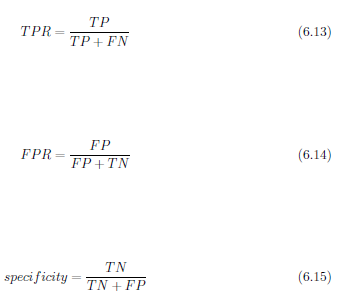

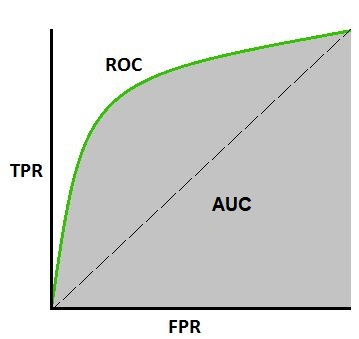

In [ ]:
# take the models results as DataFrame (this step can be skipped if the fold_summary for each model is used)
nb5km = pd.read_csv(os.path.join(base_dir, "performances_all_1km_5km/5km/all_auc_NB_5km.csv"))
bRF5km = pd.read_csv(os.path.join(base_dir, "performances_all_1km_5km/5km/all_auc_bRF_5km.csv"))
RF5km = pd.read_csv(os.path.join(base_dir, "performances_all_1km_5km/5km/all_auc_RF_5km.csv"))
NN5km = pd.read_csv(os.path.join(base_dir, "performances_all_1km_5km/5km/all_auc_NN_5km.csv"))

In [ ]:
# computing the AUC average over 5 folds for each species and for all the four algorithms

i=0
j=5
all_auc = []
while(i<=500 and j<=505):
  nb_auc = nb5km[i:j]['AUC'].mean()
  bRF_auc = bRF5km[i:j]['AUC'].mean()
  RF_auc = RF5km[i:j]['AUC'].mean()
  nn_auc = NN5km[i:j]['AUC'].mean()

  all_auc.append({
      "Naive Bayes AUC": nb_auc,
      "Balanced Random Forest AUC":bRF_auc,
      "Random Forest AUC":RF_auc,
      "DNN AUC": nn_auc

  })
  i+=5
  j+=5

In [ ]:
# plot the box plots of AUC values for all species for the 4 algorithms
fig, ax = plt.subplots(figsize=(13,10))
ax = sns.boxplot(data=all_auc, palette="Set3")
fig.savefig(os.path.join(base_dir, "boxplots_all_4alg.png"), bbox_inches="tight")

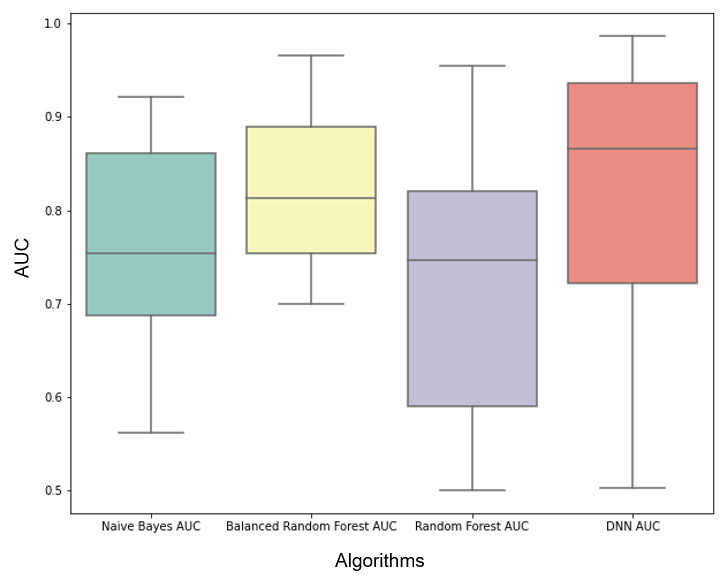

In [ ]:
# comparison of the algorithms, for the species where AUC is less than 70 %

auc_less_70 = all_auc_v2.loc[(all_auc['Naive Bayes AUC'] <0.7) & 
                         
                         (all_auc['Random Forest AUC'] <0.7) &
                      (all_auc['DNN AUC'] <0.7))]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

ax = sns.heatmap(
    auc_less_70, 
    vmin=0.5, vmax=0.8, center=0.65,
    cmap=sns.diverging_palette(240, 10, n=30),
    square=True,annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

f.savefig(os.path.join(base_dir, "evaluations_auc_V2.png"),bbox_inches = 'tight')

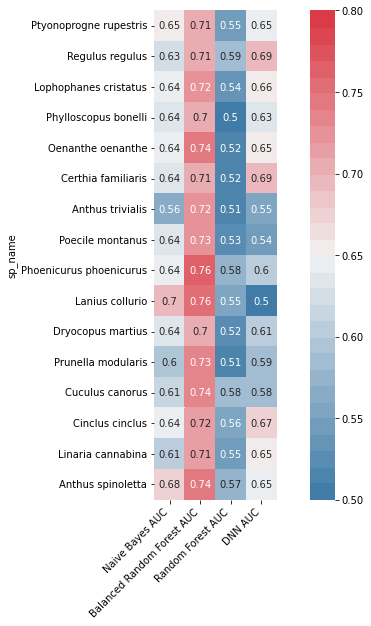

## Variable importance

After choosing balanced_RF, we assessed which environmental variables had the greatest influence on the model’s ability to predict species occurrences. In other words, we ranked the
importance of the environmental variables; the higher the importance, the greater the impact of the variable on model predictions. There are various indices for computing feature importance, one of which is Gini-based importance, which is well-known in RF algorithms (Han et al.,
2016). Gini Index, also known as Gini impurity, quantifies the likelihood of a specific feature being incorrectly classified when chosen at random. The average decrease in Gini coefficient is a measure of how each variable contributes to the homogeneity of nodes and leaves in RF trees.
The greater the value of the mean decrease Gini score, the more important the variable in the model.

The following cells compute the variable importance for an species called Golden Eagle

In [ ]:
# models are saved in .pkl format and now is loaded for Golden eagle species
model_golden = joblib.load('RFmodels/Aquila chrysaetos_RFmodel.pkl')

x2 = pd.read_csv("pres_abs_env/Aquila chrysaetos_pres_abs_env.csv", index_col=0)
x2 = x2.drop(columns=['lat','lon','pres_abs'])
importance2 = []
imp2=[]
for name, importance in zip(x2, model_golden.feature_importances_):
  (LC , impValue) = (name, importance)
  importance2.append((LC , impValue))
  imp2.append(importance) 
  print(name, "=", importance)

In [ ]:
importance2.sort(key=lambda x: -x[1], reverse=True) 
imp2.sort(reverse=False)
# Colorize the graph based on likeability:
likeability_scores = np.array(imp1)
 
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

In [ ]:
f, ax = plt.subplots(figsize=(15,10))
plt.barh(range(len(importance2)), [val[1] for val in importance2], align='center', color=color_map(data_normalizer(likeability_scores)))
plt.yticks(range(len(importance2)), [val[0] for val in importance2])
plt.yticks(rotation=0)
ax.set_title('The importance of features in predicting Golden eagle occurrence')
plt.xlabel('Feature Importance')
plt.show()
f.savefig('figures/feature_imp_golden_eagle.png')

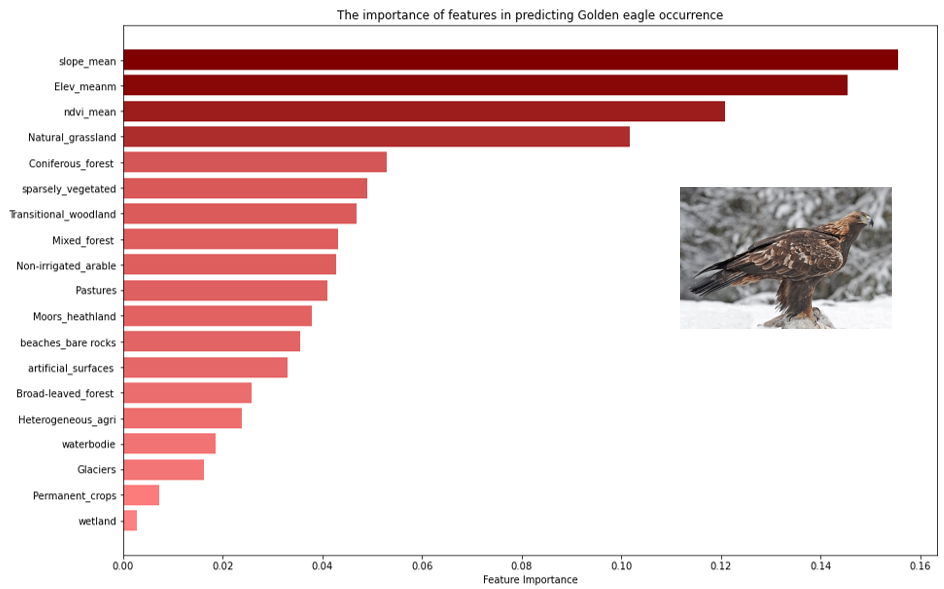

## Plot the distribution and the binary classification maps

Based on the trained balanced-RF models, for each species we obtained a distribution map and a binary classification map over switzerland. The cell bellow illustrates how these maps are generated for Golden eagle species.

In [ ]:
# first we need to load prediction surface (grids of 2 square km with computed environmental variables over Swiss)
predSurface = gpd.read_file("predSurface.shp")

In [ ]:
pred_golden = model_golden.predict(predSurface)
predprob_golden = model_golden.predict_proba(predSurface)

In [ ]:
# now let us map the probability of occurance of Golden eagle
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(15,15))
div1 = make_axes_locatable(ax1)

ax1.set_title('Map of probability of occurrence of Golden eagle')

cax1 = div1.append_axes("right", size="3%", pad=0.2)


pl1 = predSurface.plot(column= 'predprob_golden', cmap = 'RdYlGn',ax=ax1, cax=cax1, legend=True )
fig.savefig('figures/golden_eagle.png')

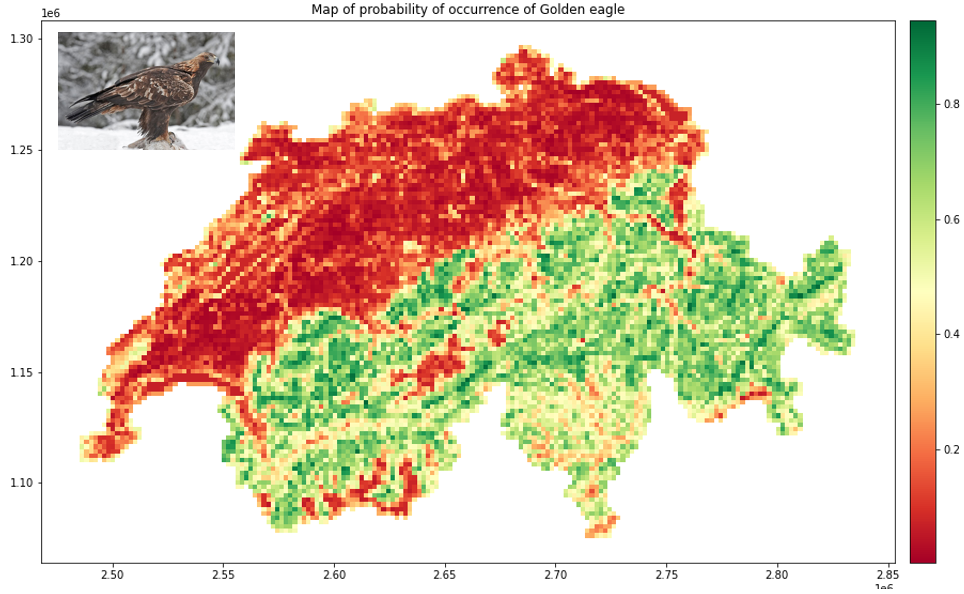

In [ ]:
# plot the binary classification map for Golden eagle

fig , ax = plt.subplots(1, figsize=(15,15))
ax.set_title('Binary classification map of Presences/Absences of Golden eagle')
predSurface.plot(column='pred_golden', ax=ax, cmap='RdYlBu', categorical=True, legend=True)
fig.savefig('figures/golden_eagle_pred.png')

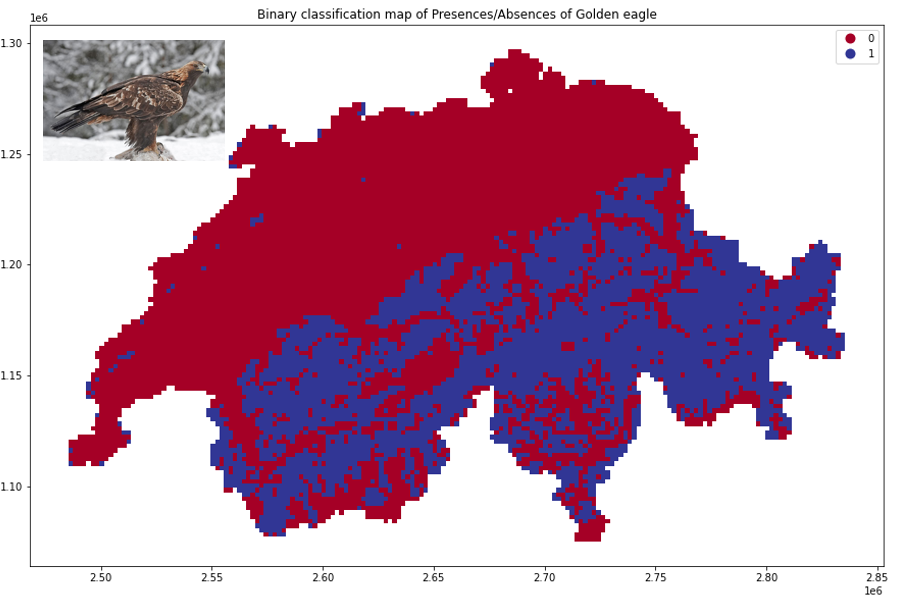